In [1]:
#Required for accessing openml datasets from Lale
!pip install 'liac-arff>=2.4.0'

In [2]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=True)

In [3]:
from sklearn.preprocessing import StandardScaler as Standard, MinMaxScaler as MinMax
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem as Nys
from lale.lib.lale import NoOp
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble.forest import RandomForestClassifier as RF
from xgboost import XGBClassifier as XGBoost
from lale.lib.lale import TopKVotingClassifier
from sklearn.metrics import accuracy_score
lale.wrap_imported_operators()

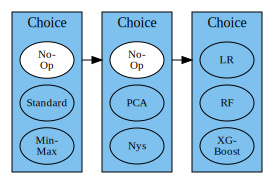

In [4]:
planned_pipeline = (NoOp | Standard | MinMax) >> (NoOp | PCA | Nys) >> (LR | RF | XGBoost)
planned_pipeline.visualize()

In [5]:
from lale.lib.lale import Hyperopt
#The optimizer supported as of now is Hyperopt and args_to_optimizer is a dictionary of values that
#Hyperopt would accept as per https://lale.readthedocs.io/en/latest/modules/lale.lib.lale.hyperopt.html
ensemble = TopKVotingClassifier(estimator=planned_pipeline, 
                                optimizer=Hyperopt,
                                args_to_optimizer={'max_evals':25, 
                                                'scoring':'accuracy'},
                                k = 5)
trained_ensemble = ensemble.fit(train_X, train_y)

100%|██████████| 25/25 [02:13<00:00,  5.36s/trial, best loss: -0.7448038005461415]


[lale schema simplifier]: The enumeration [<lale.operators.TrainablePipeline object at 0x1366e7320>] is all lale operators, but the schema fragment {'enum': [<lale.operators.TrainablePipeline object at 0x1366e7320>]} it is part of does not stipulate that it should be 'laleType':'operator'.  While legal, this likely indicate an omission in the schema.
[lale schema simplifier]: The enumeration [<lale.operators.TrainablePipeline object at 0x136750cf8>] is all lale operators, but the schema fragment {'enum': [<lale.operators.TrainablePipeline object at 0x136750cf8>]} it is part of does not stipulate that it should be 'laleType':'operator'.  While legal, this likely indicate an omission in the schema.
[lale schema simplifier]: The enumeration [<lale.operators.TrainablePipeline object at 0x136975cf8>] is all lale operators, but the schema fragment {'enum': [<lale.operators.TrainablePipeline object at 0x136975cf8>]} it is part of does not stipulate that it should be 'laleType':'operator'.  Wh

100%|██████████| 1/1 [00:05<00:00,  5.85s/trial, best loss: -0.7433112632327086]


In [6]:
#Note that you could also pass just the planned pipeline as below and Hyperopt with its default setting would be used.
ensemble = TopKVotingClassifier(estimator=planned_pipeline)

In [7]:
predictions = trained_ensemble.predict(test_X)
print(accuracy_score(test_y, predictions))

0.7484848484848485


In [8]:
best_pipeline = trained_ensemble._impl._best_estimator

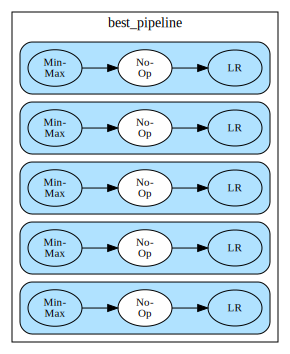

In [9]:
#The pipeline is a lale.lib.sklearn.VotingClassifier using 5 estimator pipelines.
best_pipeline.visualize()

In [10]:
best_pipeline.to_json()

{'class': 'lale.lib.sklearn.voting_classifier.VotingClassifierImpl',
 'state': 'trained',
 'operator': 'VotingClassifier',
 'label': 'best_pipeline',
 'documentation_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html',
 'hyperparams': {'estimators': [('p17', {'$ref': '../steps/pipeline'}),
   ('p11', {'$ref': '../steps/pipeline_0'}),
   ('p20', {'$ref': '../steps/pipeline_1'}),
   ('p23', {'$ref': '../steps/pipeline_2'}),
   ('p24', {'$ref': '../steps/pipeline_3'})],
  'voting': 'soft'},
 'steps': {'pipeline': {'class': 'lale.operators.TrainablePipeline',
   'state': 'trainable',
   'edges': [['min_max', 'no_op'], ['no_op', 'lr']],
   'steps': {'min_max': {'class': 'lale.lib.sklearn.min_max_scaler.MinMaxScalerImpl',
     'state': 'trainable',
     'operator': 'MinMax',
     'label': 'MinMax',
     'documentation_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html',
     'hyperparams': {},
     'is